In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np

In [3]:
image = np.random.randn(30, 32, 32)
filters = np.random.randn(32,image.shape[0], 3,3) * 0.1

In [4]:
patch = image[:, :3, :3]
patch.shape

(30, 3, 3)

In [5]:
filters[0].shape

(30, 3, 3)

In [6]:
conv  = filters[0] * patch 
conv.shape

(30, 3, 3)

In [7]:
np.sum(conv)

0.05403274901538635

In [8]:
np.linalg.norm([[1,2],[2,3]])

4.242640687119285

In [9]:
np.sqrt(np.sum(np.array([[1,2],[2,3]])**2))

4.242640687119285

# Steps

- Train loop
    - Forward
        - Conv
        - Relu
        - Conv
        - Relu
        - Dense
        - Softmax
        - Cross entropy
    
    Backprop the gradients for all the layers

    Test the code for MNIST

In [10]:
import mnist

In [11]:
mnist.init()

Download complete.
Save complete.


In [12]:
x_train, y_train, x_test, y_test = mnist.load()

In [13]:
x_train.shape

(60000, 784)

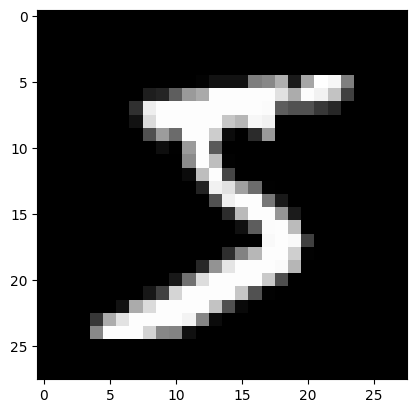

In [14]:
import matplotlib.pyplot as plt

img = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img,cmap='gray')
plt.show() # Show the image

In [15]:
from layer import Layer

In [16]:
200 * 0.1

20.0

In [17]:
class ReluLayer(Layer):
    def __init__(self, layer_name):
        super().__init__(layer_name)
        self.cached_output = None

    def forward(self, input_activations):
        self.cached_output = np.maximum(0, input_activations)
        return self.cached_output

    def backward(self, global_gradients, lr):
        local_grad = np.array(global_gradients, copy=True)
        local_grad[self.cached_output <= 0] = 0 
        return local_grad

In [18]:
class DenseLayer(Layer):
    def __init__(self, layer_name, input_nodes, output_nodes, debug = False):
        super().__init__(layer_name)
        self.debug = debug
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes

        '''
        Gloro/Xavier initialization for weights for faster convergence
        https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/
        '''
        limit = np.sqrt(2 / float(input_nodes + output_nodes))
        self.weights = np.random.normal(0.0, limit, size = (input_nodes, output_nodes))

        ''' 
        No initialization is required for bias,
        https://cs231n.github.io/neural-networks-2/#:~:text=Initializing%20the%20biases
        '''
        self.bias = np.zeros((1, output_nodes))

        #we need to cache the input and output from this layer for the purpose of backprop
        self.cached_input = None
        self.cached_output = None

    # overriden
    def forward(self, input_activations):
        '''

        @param input_activations - Output of previous layer
        @return softmax of logits

        Dense layer forward prop
        1. Flatten the input
        2. Dot product with weights and add the bias
        3. Cache the input and logits for backpop
        4. Apply softmax on logits and return it
        '''

        shape = input_activations.shape
        layer_input = input_activations.ravel().reshape(shape[0], -1)
        layer_logits = np.dot(layer_input, self.weights) + self.bias

        self.cached_input = layer_input
        self.cached_output = layer_logits
        if self.debug:
            print(f"Cached output {self.cached_output}, ip shape {layer_input.shape}, op shape {layer_logits.shape}")
        return self.cached_output


    #overriden
    def backward(self, global_gradient, current_lr):
        '''
        @param global_gradient, gradients from the previous layer
        @param current_lr 


        @returns The gradient of Loss w.r.t to the input to this layer
        i.e the input_activations recieved during forward pass.

        Dense layer backward prop
        1. Calculate the gradients w.r.t to the weights
        2. Calculate the gradients w.r.t to the received activations
        and return it for usage in other previous layers.

        '''
        output_grad  = global_gradient
        samples = global_gradient.shape[0]

        assert output_grad.shape[1] == self.weights.T.shape[0]
        assert self.cached_input.T.shape[1] == output_grad.shape[0]

        input_grad = np.dot(output_grad, self.weights.T) / samples
        weight_grad = np.dot(self.cached_input.T, output_grad) / samples
        
        if self.debug:
            print(f"weights shape {self.weights.shape}, weight grad shape {weight_grad.shape}, input_shape {self.cached_input.shape}, input_grad shape {input_grad.shape}, ")

        self.weights -= current_lr * weight_grad
        self.bias -= current_lr * np.sum(output_grad, axis=0, keepdims=True) 

        return input_grad
    



In [19]:
dense_1 = DenseLayer("Dense_1",784, 10)

In [20]:
dense_1.forward(np.random.randn(1,784)).shape

(1, 10)

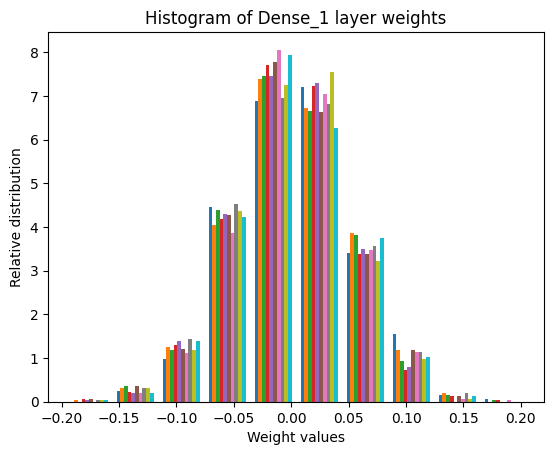

In [21]:
import utils
utils.plot_histogram(dense_1.layer_name, dense_1.weights)

In [22]:
28*28

784

### Model

In [23]:
from activations import Softmax_Categorical_CrossEntropy

In [24]:
dense_1 = DenseLayer("Dense_1", 784, 14)
relu_1 = ReluLayer("relu_1")
dense_2 = DenseLayer("Dense_2", 14, 10)

softmax_loss = Softmax_Categorical_CrossEntropy("Softmax_CCE_1")

In [25]:
y = dense_1.forward(img.reshape(1, 28, 28))
relu_y = relu_1.forward(y)
y = dense_2.forward(relu_y)

true_labels = y_train[0].reshape(1,1)
loss = softmax_loss.forward(y, true_labels)
print(f"loss {loss}, ypredicted {y}")

# gradients /= samples

global_grad = softmax_loss.backward(softmax_loss.cached_output, true_labels)
print(global_grad.shape)

global_grad = dense_2.backward(global_grad, 1e-6)
print(global_grad.shape)
global_grad = relu_1.backward(global_grad, 1e-6)
global_grad = dense_1.backward(global_grad, 1e-06)

Softmax output shape (1, 10), ytrue shape (1, 1)
Softmax_y shape (1, 10), samples 1, y_true (1, 1)
loss [[16.11809565]], ypredicted [[ -16.89724332 -198.7256326   100.95502655  119.52536833  130.50110187
   -99.45481922 -235.3093063   116.98542551   71.69121046   23.68520176]]
y softmax shape (1, 10), y_true shape (1, 1)
(1, 10)
(1, 14)


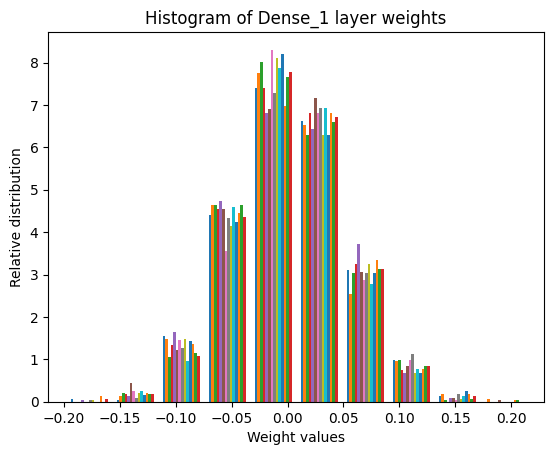

In [26]:
utils.plot_histogram("Dense_1", dense_1.weights)

### Sequential

In [33]:
from model import Sequential

np.random.seed(42)

dense_1 = DenseLayer("Dense_1", 784, 14, debug=False)
relu_1 = ReluLayer("relu_1")
dense_2 = DenseLayer("Dense_2", 14, 10, debug=False)

layers = [dense_1, relu_1, dense_2]
sequential_model = Sequential(layers)

In [34]:
x_train.shape

(60000, 784)

In [40]:
y_p = np.random.randn(32,10)
y_p.shape

(32, 10)

In [42]:
y_p

array([[ 0.57550873, -1.66323448,  2.13828232, -1.65125384,  0.15642202,
        -0.15044775, -0.10690649,  0.86982568, -0.7078108 , -0.43270763],
       [-1.1466052 ,  1.12215885,  0.26608542,  0.63721809,  0.81198385,
         1.99141276,  1.81694583,  0.32304162,  0.1579627 , -0.53214187],
       [ 0.74415778,  0.70711296, -0.72939133,  0.71978295,  1.00835449,
        -1.12164662,  0.18991397, -0.06572894, -0.00538651, -0.95265323],
       [-1.82655576, -0.7554163 , -0.89545831,  0.35322307,  0.36951312,
         0.31259223, -1.39673067, -1.11955837, -0.61667269,  0.02314301],
       [-0.33510755,  0.3106391 ,  0.97547032, -0.99929381, -0.9612705 ,
         0.13535999, -0.08203064,  0.74336356,  0.00757666,  1.74052123],
       [-1.58787477,  0.84021686,  0.1993262 , -1.40300107, -2.06795929,
        -1.12501907,  1.20908771,  1.09523156, -0.12865249, -0.36227298],
       [-0.856097  , -0.18738932, -0.47416169,  1.70994205, -1.2365556 ,
         0.3924377 ,  1.75707134,  0.77458282

In [46]:
np.argmax(y_p, axis=1).shape

(32,)

In [35]:
x_preprocessed = x_train[:1000]
y_preprocessed = y_train[:1000]

x_preprocessed = utils.minmax_normalize(x_preprocessed)

In [38]:
sequential_model.train([x_preprocessed, y_preprocessed], [None, None], [None, None], 20, 32, True)

Xbatch size (32, 784), y_predicted_shape (32, 10), y_true shape (32,)
Softmax output shape (32, 10), ytrue shape (32,)
Softmax_y shape (32, 10), samples 32, y_true (32,)
y softmax shape (32, 10), y_true shape (32,)
global grad shape (32, 10)
Xbatch size (32, 784), y_predicted_shape (32, 10), y_true shape (32,)
Softmax output shape (32, 10), ytrue shape (32,)
Softmax_y shape (32, 10), samples 32, y_true (32,)
y softmax shape (32, 10), y_true shape (32,)
global grad shape (32, 10)
Xbatch size (32, 784), y_predicted_shape (32, 10), y_true shape (32,)
Softmax output shape (32, 10), ytrue shape (32,)
Softmax_y shape (32, 10), samples 32, y_true (32,)
y softmax shape (32, 10), y_true shape (32,)
global grad shape (32, 10)
Xbatch size (32, 784), y_predicted_shape (32, 10), y_true shape (32,)
Softmax output shape (32, 10), ytrue shape (32,)
Softmax_y shape (32, 10), samples 32, y_true (32,)
y softmax shape (32, 10), y_true shape (32,)
global grad shape (32, 10)
Xbatch size (32, 784), y_predict

Traceback (most recent call last):
  File "c:\Users\shivs\anaconda3\envs\pytorchlearning\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\shivs\AppData\Local\Temp\ipykernel_5760\330113264.py", line 1, in <module>
    sequential_model.train([x_preprocessed, y_preprocessed], [None, None], [None, None], 20, 32, True)
  File "d:\MS\Fall2023\ML-6375\Project\code\ML6375-Project\CNN\model.py", line 65, in train
    train_acc = accuracy(y_predictions, y_permuted)
  File "d:\MS\Fall2023\ML-6375\Project\code\ML6375-Project\CNN\utils.py", line 34, in accuracy
    return ((y_predicted == y_true).mean()) * 100
ValueError: operands could not be broadcast together with shapes (1000,) (32,) 

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\shivs\anaconda3\envs\pytorchlearning\lib\site-packages\IPython\core\interactiveshell.py", line 

8

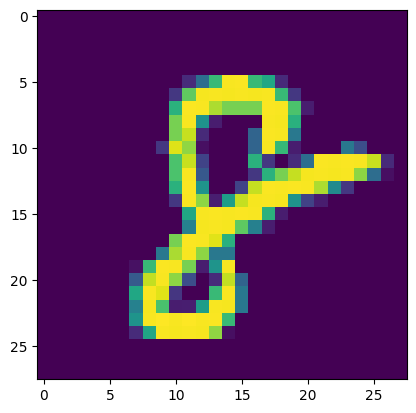

In [ ]:
test_image = utils.minmax_normalize(x_test[np.random.randint(0,10000)])
plt.imshow(test_image.reshape(28, 28))

np.argmax(sequential_model._forward(np.expand_dims(test_image, 0)))

In [ ]:
x_train.shape

(60000, 784)

In [ ]:
permuted_idx = np.random.permutation(range(x_train.shape[0]))
x_permuted = x_train[permuted_idx]
y_permuted = y_train[permuted_idx]

9

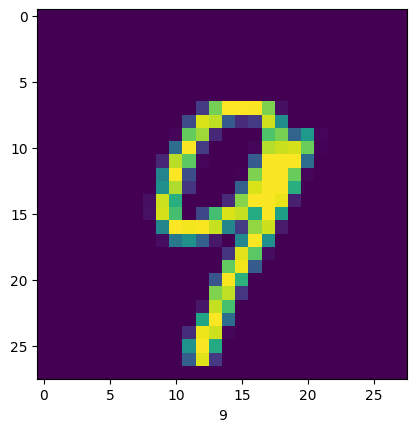

In [ ]:
idx = np.random.randint(0,10000)
test_image = utils.minmax_normalize(x_permuted[idx])

plt.imshow(test_image.reshape(28, 28))
plt.xlabel(y_permuted[idx])

np.argmax(sequential_model._forward(np.expand_dims(test_image, 0)))

In [ ]:
print

9

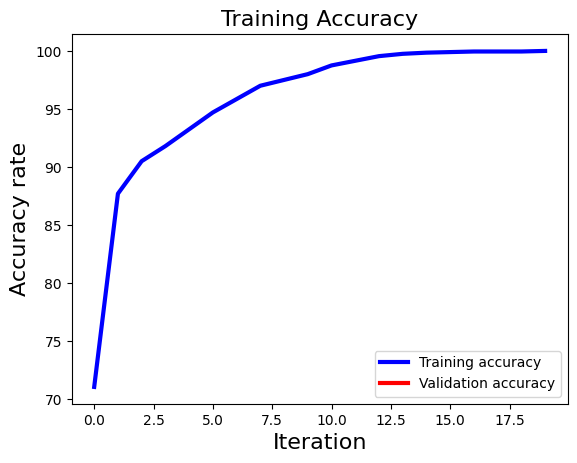

In [ ]:
utils.plot_accuracy_curve(sequential_model.train_accuracy, sequential_model.test_accuracy)

In [ ]:
# def generate_batches(x: np.array, y: np.array, batch_size: int):
#     """
#     :param x - features array with (n, ...) shape
#     :param y - one hot ground truth array with (n, k) shape
#     :batch_size - number of elements in single batch
#     ----------------------------------------------------------------------------
#     n - number of examples in data set
#     k - number of classes
#     """
#     for i in range(0, x.shape[0], batch_size):
#         yield (
#             x.take(indices=range(i, min(i + batch_size, x.shape[0])), axis=0),
#             y.take(indices=range(i, min(i + batch_size, y.shape[0])), axis=0),
#         )


In [ ]:
x_train.shape

(60000, 784)

In [ ]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [ ]:
y_t = np.expand_dims(y_train, 1)

In [ ]:
y_t.shape

(60000, 1)

In [ ]:
y_train.shape

(60000,)

In [ ]:
# for x, y in generate_batches(x_train, y_t, 1):
#     print(x.shape, y.shape)